In [1]:
library(tidyverse)
library(ggrepel) # for text labels
library(vegan)
library(taxize)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: permute
Loading required package: lattice
This is vegan 2.4-3


In [2]:
metadata <- read_tsv("../ref/varroa.txt")
head(metadata)
microbes <- read_csv("../data/R/microbes.csv.gz")
head(microbes)

Parsed with column specification:
cols(
  id = col_character(),
  collectedHost = col_character(),
  species = col_character(),
  fedHost = col_character(),
  ceranaReads = col_integer(),
  melliferaReads = col_integer(),
  year = col_integer(),
  country = col_character()
)


id,collectedHost,species,fedHost,ceranaReads,melliferaReads,year,country
VD149,cerana,VD,cerana,1773,76,1996,Vietnam
VD150_2,mellifera,VD,mellifera,26,218,1996,Vietnam
VD153_2,mellifera,VD,mellifera,0,5824,1996,South Korea
VD159_1,mellifera,VD,mellifera,14,5707,1996,South Korea
VD212,cerana,VD,cerana,56,0,1996,South Korea
VD474_1,mellifera,VD,mellifera,52,648,1998,Vietnam


Parsed with column specification:
cols(
  id = col_character(),
  taxId = col_integer(),
  count = col_integer()
)


id,taxId,count
VJ854_1,1,4415
VJ854_1,1001585,1
VJ854_1,1002804,16
VJ854_1,1002809,91
VJ854_1,1003195,12
VJ854_1,1004952,2


In [3]:
dat <- microbes %>% filter (count >= 100) %>% spread(taxId, count, fill = 0) 
dim(dat)
dat[,-1] <- sweep(dat[,-1],1,rowSums(dat[,-1]),`/`) # normalize libraries
dat.dist <- vegdist(dat[,-1])

[1]  44 987

In [4]:
microbes.mds <- metaMDS(dat.dist, trace = F)

In [5]:
plotData <- cbind(microbes.mds$points, dat[,1]) %>% 
left_join(metadata, by = "id")
head(plotData)

MDS1,MDS2,id,collectedHost,species,fedHost,ceranaReads,melliferaReads,year,country
-0.09333891,0.017017089,VD149,cerana,VD,cerana,1773,76,1996,Vietnam
-0.03549357,-0.034211044,VD150_2,mellifera,VD,mellifera,26,218,1996,Vietnam
-0.11011133,-0.153114104,VD153_2,mellifera,VD,mellifera,0,5824,1996,South Korea
-0.02554536,-0.003747973,VD159_1,mellifera,VD,mellifera,14,5707,1996,South Korea
0.03493995,0.136345724,VD212,cerana,VD,cerana,56,0,1996,South Korea
0.06051322,-0.209932148,VD474_1,mellifera,VD,mellifera,52,648,1998,Vietnam


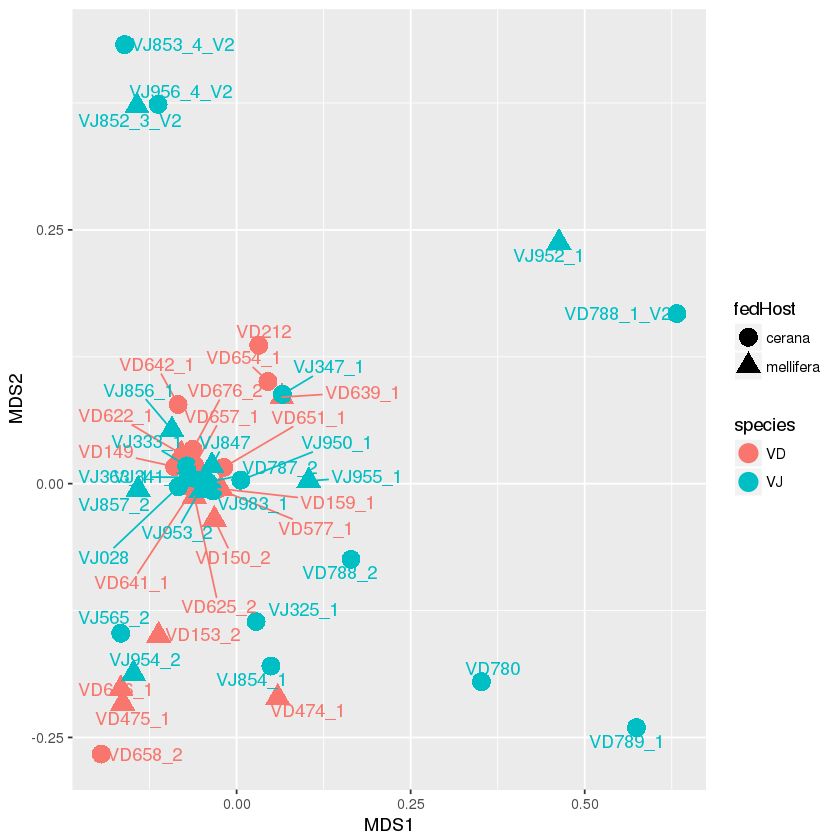

In [54]:
ggplot(plotData,aes(MDS1, MDS2, shape = fedHost, color = species)) + 
geom_point(size=5) + geom_text_repel(aes(label = id)) 

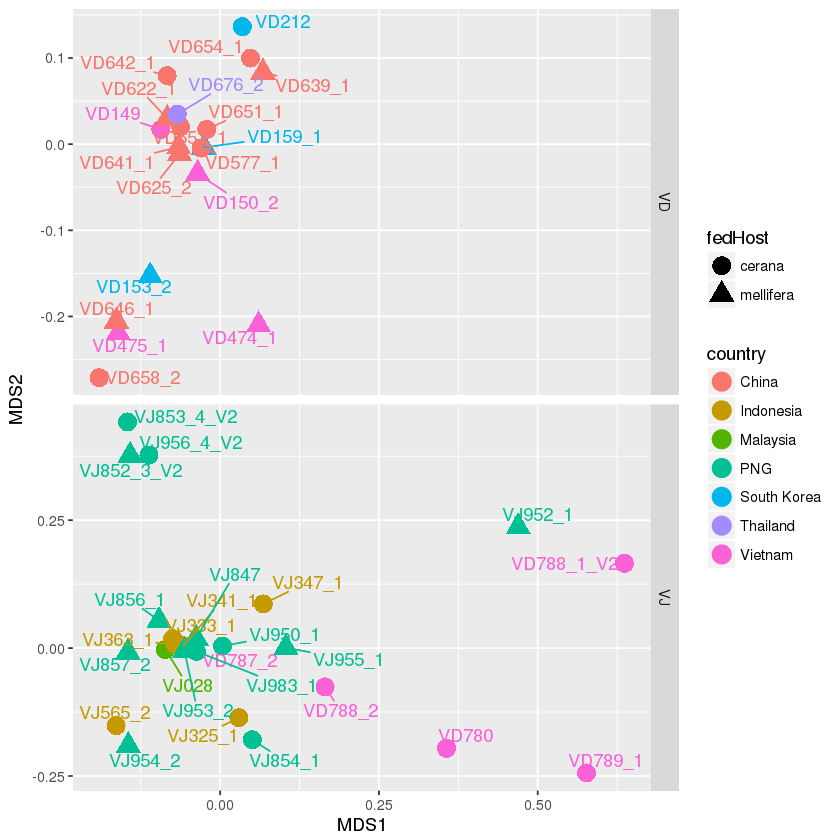

In [7]:
ggplot(plotData, aes(MDS1, MDS2, shape = fedHost, color = country)) + 
geom_point(size=5) + geom_text_repel(aes(label = id)) + 
facet_grid(species~., scales = "free")

In [115]:
top20taxa <- head(colnames(dat[,-1])[order(colMeans(dat[,-1]), 
                                           decreasing = T)],20)
ncbi_name <- function (x) return(ncbi_get_taxon_summary(x)$name)
(top20taxaNames <- lapply(top20taxa, FUN = ncbi_name))

[[1]]
[1] "Burkholderia dolosa PC543"

[[2]]
[1] "Gordonibacter massiliensis"

[[3]]
[1] "Proteobacteria"

[[4]]
[1] "Xanthomonas fuscans subsp. fuscans"

[[5]]
[1] "Pseudomonas fluorescens"

[[6]]
[1] "Enterococcus faecalis"

[[7]]
[1] "Wolbachia endosymbiont of Cimex lectularius"

[[8]]
[1] "Negativicoccus massiliensis"

[[9]]
[1] "Enterobacter cloacae"

[[10]]
[1] "Bacteria"

[[11]]
[1] "root"

[[12]]
[1] "Gammaproteobacteria"

[[13]]
[1] "cellular organisms"

[[14]]
[1] "Cutibacterium acnes"

[[15]]
[1] "Bacillus cereus"

[[16]]
[1] "Sulfolobus acidocaldarius"

[[17]]
[1] "Enterobacteriaceae"

[[18]]
[1] "Parasaccharibacter apium"

[[19]]
[1] "Mycobacterium kansasii"

[[20]]
[1] "Campylobacter jejuni"

In [45]:
topDat <- dat[,c("id", top20taxa)]
colnames(topDat) <- c("id", top20taxaNames)

In [79]:
topDat2 <- left_join(topDat, metadata, by = "id") %>% gather(microbe, proportion, 2:21)

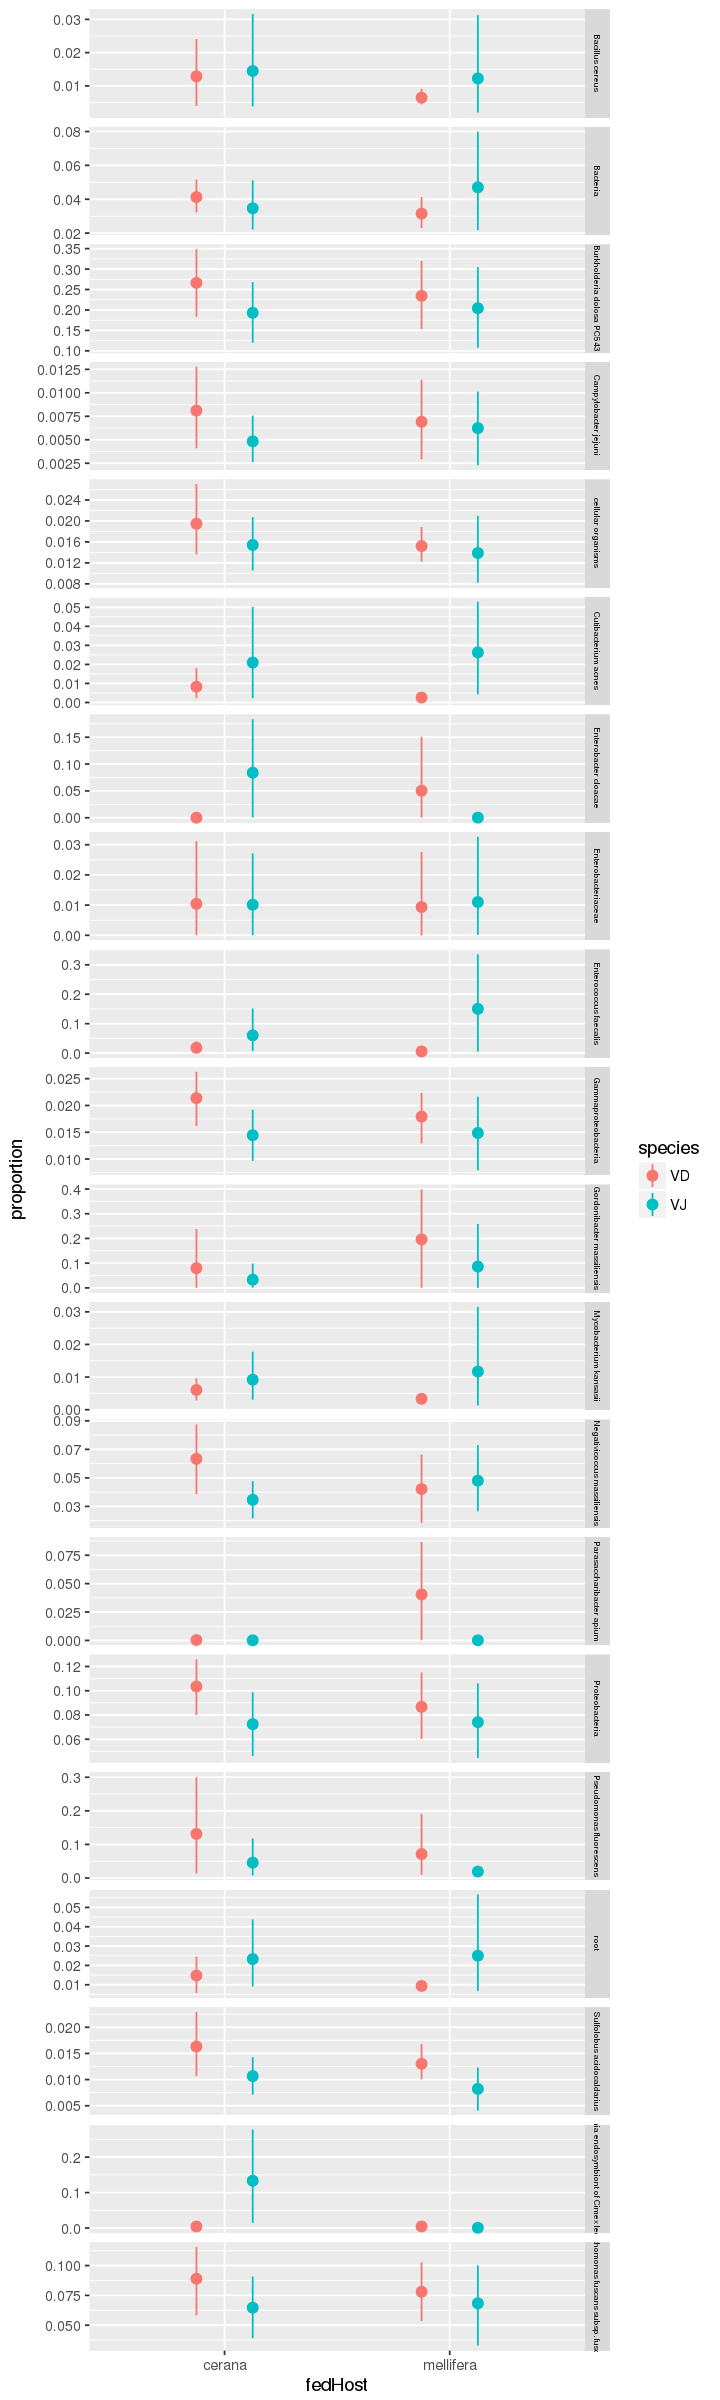

In [106]:
options(repr.plot.width=6, repr.plot.height=20)
ggplot(topDat2, aes(fedHost, proportion, color = species)) + 
facet_grid(microbe~., scales = "free_y") + 
stat_summary(fun.data = "mean_cl_boot", position=position_dodge(width=0.5)) +
theme(strip.text.y = element_text(size = 5))

In [114]:
mrpp(dat[,-1], metadata$fedHost, permutations = 999)$Pvalue
mrpp(dat[,-1], metadata$species, permutations = 999)$Pvalue

[1] 0.575

[1] 0.176

There doesn't seem to be much overall differentiation between the microbiota of the mites.

#### Ideas
- The most common bacterium _Burkholderia dolosa_ is highly drug resistant. Could it be playing a role in breaking down miticides?
- Nothing is really known about Gordonibacter, what is is?